In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

Public data used in this notebook comes from:

ONS price paid data: https://www.gov.uk/government/statistical-data-sets/price-paid-data-downloads

National Statistics Postcode Lookup UK: https://data.gov.uk/dataset/7ec10db7-c8f4-4a40-8d82-8921935b4865/national-statistics-postcode-lookup-uk

In [3]:
'''
--- DATASET INFO ---
ID                643193 non-null int64
Price_Paid        643193 non-null int64
Date              643193 non-null object
Post_code         639255 non-null object
Property_Type     643193 non-null object
New_build         643193 non-null object
Estate_type       643193 non-null object
Building_Name     643193 non-null object
Building_Name2    83519 non-null object
Street_Name       630497 non-null object
Locality          237963 non-null object
Town              643193 non-null object
District          643193 non-null object
County            643193 non-null object
Unknown           643193 non-null object
Unknown2          643193 non-null object

Data item     Explanation (where appropriate)
Transaction unique identifier     A reference number which is generated automatically recording each published sale.
The number is unique and will change each time a sale is recorded.
Price     Sale price stated on the transfer deed.
Date of Transfer     Date when the sale was completed, as stated on the transfer deed.
Postcode     This is the postcode used at the time of the original transaction. Note that postcodes can be reallocated
and these changes are not reflected in the Price Paid Dataset.
Property Type     D = Detached, S = Semi-Detached, T = Terraced, F = Flats/Maisonettes, O = Other
Note that:
- we only record the above categories to describe property type, we do not separately identify bungalows.
- end-of-terrace properties are included in the Terraced category above.
- ‘Other’ is only valid where the transaction relates to a property type that is not covered by existing values.
Old/New     Indicates the age of the property and applies to all price paid transactions, residential and non-residential.
Y = a newly built property, N = an established residential building
Duration     Relates to the tenure: F = Freehold, L= Leasehold etc.
Note that HM Land Registry does not record leases of 7 years or less in the Price Paid Dataset.
PAON     Primary Addressable Object Name. Typically the house number or name.
SAON     Secondary Addressable Object Name. Where a property has been divided into separate units (for example, flats),
the PAON (above) will identify the building and a SAON will be specified that identifies the separate unit/flat.
Street      
Locality      
Town/City      
District      
County      
PPD Category Type     Indicates the type of Price Paid transaction.
A = Standard Price Paid entry, includes single residential property sold for full market value.
B = Additional Price Paid entry including transfers under a power of sale/repossessions, buy-to-lets (where they can be
 identified by a Mortgage) and transfers to non-private individuals.

Note that category B does not separately identify the transaction types stated.
HM Land Registry has been collecting information on Category A transactions from January 1995. Category B transactions
were identified from October 2013.
Record Status - monthly file only     Indicates additions, changes and deletions to the records.(see guide below).
A = Addition
C = Change
D = Delete.

Note that where a transaction changes category type due to misallocation (as above) it will be deleted from the original
category type and added to the correct category with a new transaction unique identifier.
'''

print("Reading in Land Registry data...")

df = pd.read_csv(os.path.join(os.getcwd(),'0. Data/pp_complete.csv'),
                 names=['Trans_id', 'price', 'date', 'postcode', 'Property', 'Age','Duration',
                        'PAON', 'SOAN', 'Street', 'Locality', 'Town', 'District', 'County', 'PPD', 'Rec_Status'])

# Converting Date to datetime format
df['Date'] = pd.to_datetime(df['date'], format='%Y/%m/%d %H:%M')
df.drop(['Trans_id','date'], axis=1, inplace=True)

# Creating month and quarter dates
df['Sale_month'] = df.Date.dt.to_period('M')
df['Sale_quarter'] = df.Date.dt.to_period('Q')


# Function to remove blanks from postcodes
def remove_blanks(row):
    string = str(row['postcode'])
    string = string.strip().replace(" ", "").upper()
    return string

# Returns the district level postcode
def pstcde_district(row):
    string = str(row['Postcode'])
    string = string[:-3]
    return string

def pstcde_district2(row):
    string = str(row['Postcode'])
    string = string[:-2]
    return string

# Applying function to remove blanks from postcodes strings
df['Postcode'] = df.apply(remove_blanks, axis=1)
df['Pstcde_District'] = df.apply(pstcde_district, axis=1)
df['Postcode_Area'] = df.Pstcde_District.str.extract('([A-Z]*)', expand=False)

# Processing strings to produce address column
df.SOAN.replace(np.nan,'', regex=True, inplace=True)
df.PAON.replace(np.nan,'', regex=True, inplace=True)
df.Street.replace(np.nan,'', regex=True, inplace=True)
df.Postcode.replace(np.nan,'', regex=True, inplace=True)
df['SOAN'] = df.SOAN.str.upper()
df['PAON'] = df.PAON.str.upper()
df['Street'] = df.Street.str.upper()
df['Postcode'] = df.Postcode.str.upper()
df['Address'] = df['PAON'] + " " + df['SOAN'] + " " + df['Street'] + " " +  df['Postcode']
df.Address.replace('  ',' ', regex=True, inplace=True)

# Modifying the dataframe to save on some space
df.price = df.price.astype('int32')
df = df[['price','Property','Age','Duration','PPD',
         'Date','Sale_quarter','Postcode','Pstcde_District','Postcode_Area','Address']]

#Removing properties which didn't sell for their full market value
df = df[df['PPD']=='A']


#Reading in National Statistics Postcode Lookup UK data
print("Reading in National Statistics Postcode Lookup data...")
df_pstcde  =  pd.read_csv(os.path.join(os.getcwd(),
                                       '0. Data/National_Statistics_Postcode_Lookup_UK.csv'),header=0)

df_pstcde = df_pstcde[['Postcode 1','Easting','Northing','Output Area Classification Name',
                       'Region Name','Longitude','Latitude']]
df_pstcde['Postcode'] = df_pstcde['Postcode 1']
df_pstcde.drop('Postcode 1',axis=1,inplace=True)

df_pstcde.Postcode.replace(' ','',regex=True, inplace=True)
df_pstcde.Postcode = df_pstcde.Postcode.str.upper()

def simplify(row):
    string = row['Output Area Classification Name']
    string = string.split(";")[0]
    return string

df_pstcde['Output Area Classification Name'] = df_pstcde.apply(simplify,axis=1)
    
print("Merging dataframes...")
print(df.shape)
df2 = df.merge(df_pstcde,how='inner',on='Postcode')
print(df2.shape)

#Sorting data before saving down
df2_sorted = df2.sort_values(by=['Address','Sale_quarter'])

print("Saving data...")
df2_sorted.to_csv(os.path.join(os.getcwd(),'0. Data/Source_0.csv'), index=False)

df2_lite = df2_sorted[:100000]
df2_lite.to_csv(os.path.join(os.getcwd(),'0. Data/Source_0_lite.csv'), index=False)

df2_sampled = df2.sample(frac=0.1)
df2_sampled.to_csv(os.path.join(os.getcwd(),'0. Data/Source_0_sampled.csv'), index=False)

df2.head()

Reading in Land Registry data...
Reading in National Statistics Postcode Lookup data...
Merging dataframes...
(23195338, 11)
(23139738, 17)
Saving data...


,price,Property,Age,Duration,PPD,Date,Sale_quarter,Postcode,Pstcde_District,Postcode_Area,Address,Easting,Northing,Output Area Classification Name,Region Name,Longitude,Latitude
0,166500,D,Y,F,A,1995-11-22,1995Q4,CM234PA,CM23,CM,19 MAYFLOWER GARDENS CM234PA,546942,220563,Suburbanites,East of England,0.132636,51.864303
1,166500,D,Y,F,A,1995-12-01,1995Q4,CM234PA,CM23,CM,22 MAYFLOWER GARDENS CM234PA,546942,220563,Suburbanites,East of England,0.132636,51.864303
2,121500,D,Y,F,A,1995-05-26,1995Q2,CM234PA,CM23,CM,33 MAYFLOWER GARDENS CM234PA,546942,220563,Suburbanites,East of England,0.132636,51.864303
3,148950,D,Y,F,A,1995-02-10,1995Q1,CM234PA,CM23,CM,1 MAYFLOWER GARDENS CM234PA,546942,220563,Suburbanites,East of England,0.132636,51.864303
4,119950,D,Y,F,A,1995-04-28,1995Q2,CM234PA,CM23,CM,6 MAYFLOWER GARDENS CM234PA,546942,220563,Suburbanites,East of England,0.132636,51.864303


# 1. House Price Indices

Often when the performance of the housing market is discussed in media you'll see House Price indices such as the Halifax House price index, or nationwide index being quoted. These indices aim to provides a measure of the relative increase in value of property.

When considering how to measure this growth care must be taken. For example, as shown in the diagram below, the distribution of property price paid is not normally distributed, meaning that simply taking thee mean price paid over time may not provide an index which is representative of a typical property.

We could instead maybe just take the median house price? This may resolve the issue described above, however this measurement may be suscetable to changes in composition of proeprties reahcing sale, resulting in short term inaccuracies as the composition of sales fluctuate.

Thus, many house price indices provided by banks and governement offices use methods which try to resolve both these issues, either through the use of some sort of stratification or hedonic regression. This section will focus on the use of hedonic regression.

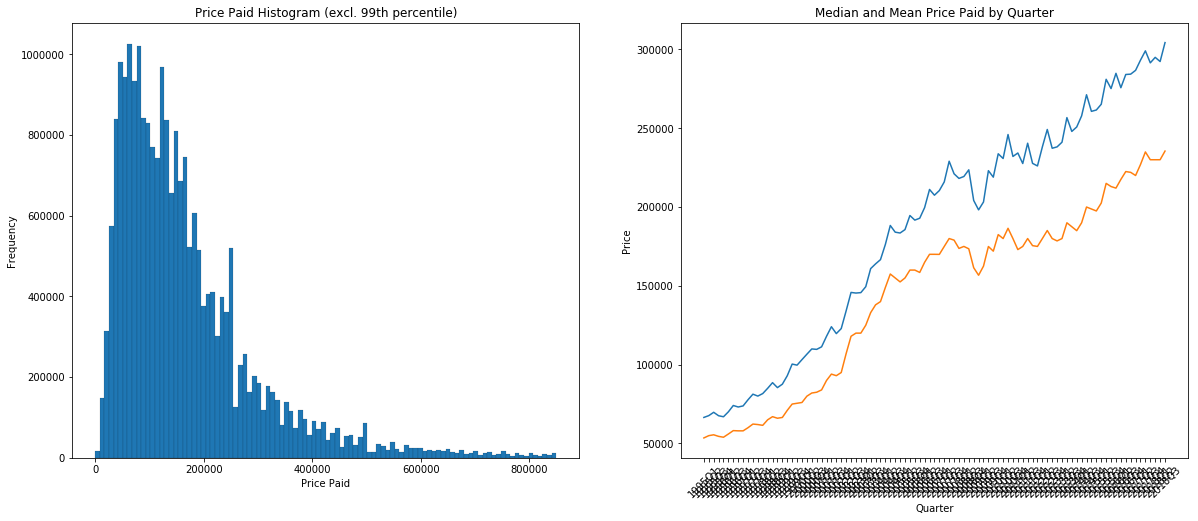

In [55]:
#Calculate median house price by quarter
df2 = pd.read_csv(os.path.join(os.getcwd(),'0. Data/Source_0.csv'))
df2['Date'] = pd.to_datetime(df2['Date'])
df_median = df2.groupby(['Sale_quarter'])['price'].agg(['median','mean'])

fig = plt.figure(figsize=(20, 8))
plt.subplot(1,2,1)
df2[df2['price']<=df2.price.quantile(0.99)].price.plot.hist(bins=100, edgecolor='black', linewidth=0.1)
plt.title("Price Paid Histogram (excl. 99th percentile)")
plt.xlabel("Price Paid")

plt.subplot(1,2,2)
plt.plot(list(df_median.index),df_median['mean'].values)
plt.plot(list(df_median.index),df_median['median'].values)
plt.title("Median and Mean Price Paid by Quarter")
plt.xticks(rotation=45)
plt.xlabel("Quarter")
plt.ylabel("Price")
plt.show()

## Hedonic Regression 1.1
The hedonic regression aims to break down the value of a property into its constiuent components from which it derives its value. For example, a property valued at £200,000 may derive £100,000 of its value as it's located in a city centre, £50,000 due to its large size and an additional £50,000 due to its high quality decorations and furnishings. This can be expressed forumlaically as:

$$ value_p = \beta_0 + \sum_{k=1}^{M}{\beta_k x_{kp}}$$ 

Where $x_{kp}$ is a vector consisting of dummy variables detailing the attributes of property $p$, and $\beta_{0}$ and $\beta_{k}$ the coefficients to be determined via regression. Note, that overtime it is likely that the value of these compenents is likely to change over time, either due to inflation or changes in supply and demand. We can therefore re-form our model as so:

$$ value_{p}^{t} = \beta_{0}^{t} + \sum_{k=1}^{M}{\beta^{t}_{k} x_{kp}}$$

Using these coefficients we can approximate the value of a property of our own definition overtime. In the case of a house price index, this property will be defined by measuring the average property in the market, e.g. a typical property may be 30% flat, 60% Terraced and 10% Semi-Detached.

$$ \bar{x}_k = \dfrac{1}{N}\sum_{p=1}^{N}{x_{kp}} $$

Inputting our "typical" property we can then generate a time series for the value of our typical property through time. An index can then be created by simply choosing a period to baseline and divding by the value at said period $T$

$$ index^t = 
\dfrac{value^t}{value^T}
=
\dfrac{\beta_{0}^{t} + \sum_{k=1}^{M}{\beta^{t}_{k} \bar{x}_{k}}}{\beta_{0}^{T} + \sum_{k=1}^{M}{\beta^{T}_{k} \bar{x}_{k}}} $$

Note, if reader may find the reasoning for creating an index and then using that, rather than just applying the hedonic regression directly to each property perplexing, they are justified.

Within our data we have the property type, location, leasehold type, Property age (old or new), and a postcode area classification as our property attributes. Before performing the regression we will also need to transform our traget variable 'price' so that it is normally distributed to help ensure that our model is the BLUE (Best Linear Unbiased Estimator). Thus our model becomes:

$$ \ln({value_p^t})= \beta_0^t + \sum{\beta_k^t x_{kp}}$$


In [71]:
reg_data = df2[['Date','price','Property','Age','Duration','Output Area Classification Name']]

# Remapping some of the variables
reg_data.loc[:,'Sale_quarter'] = reg_data.Date.dt.to_period('Q')
reg_data['log_price'] = np.log(reg_data.price)

property_map = {'F':'Flat',
	'S':'Semi_Detached',
	'D':'Detached',
	'O':'Other',
	'T':'Terraced'}
reg_data['Property'] = reg_data['Property'].map(property_map)

age_map = {'N':'Old','Y':'New'}
reg_data['Age'] = reg_data['Age'].map(age_map)

Duration_map = {'F':'Freehold','L':'Leasehold','U':'Undeclared'}
reg_data['Duration'] = reg_data['Duration'].map(Duration_map)

# Converting variables into dummy variables
dummy_vars = ['Property','Age','Duration','Output Area Classification Name']
reg_data_2 = pd.get_dummies(reg_data, columns=dummy_vars, prefix='dum')

# Creating a list of periods to loop through
period_list = pd.date_range(start='1/1/1995', periods=92, freq='Q').to_period('Q')

import sklearn
from sklearn.linear_model import Ridge
model = Ridge()

for quarter in period_list:
    
    print("Processing Quarter %s" %quarter)
    
    df_quarter = reg_data_2[reg_data_2['Sale_quarter']==quarter]

    X = df_quarter.drop(['Date','price','log_price','Sale_quarter'],axis=1)
    X_np = X.values
    y_np = df_quarter['log_price'].values

    model.fit(X_np,y_np)
    
    #Saving params
    params = list(model.coef_)
    intercept = list(model.intercept_)
    params.append(intercept)
    
    #Saving params labels
    columns = list(X.columns)
    columns.append(['intercept'])
    
    quarter_params = pd.DataFrame(params,index=columns)
    
    print(quarter_params.head())
    

c:\program files\python36\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
c:\program files\python36\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
c:\program files\python36\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-

Processing Quarter 1995Q1


KeyboardInterrupt: 

In [83]:
df_district_pc = pd.DataFrame()
df_district.dropna(how='any',axis=1,inplace=True)
for col in df_district:
    df_district_pc[col]=df_district[col]/df_district[col].shift(1)-1
df_district_pc.head()
df_district_pc.dropna(how='any',inplace=True,axis=0)
df_district_pc.head()

from statsmodels.tsa.seasonal import seasonal_decompose

df_district_pc.index= df_district_pc.index.to_timestamp()

for col in df_district_pc:
    #df_district_pc.loc[:,col] = seasonal_decompose(df_district.loc[:,col], model='additive')
    df_district_pc.loc[:,col] = seasonal_decompose(df_district_pc.loc[:,col], model='additive').trend
df_district_pc.dropna(how='any',axis=0, inplace=True)
df_district_pc.to_csv(os.path.join(os.getcwd(),'0. Data/Median_PP_by_District_pc_SA.csv'), index=True)

As you can see above there's a lot of seasonality going on in the data, making it difficult to see trends. Removing seasonality from the time series should help with this.

In [73]:
from statsmodels.tsa.seasonal import seasonal_decompose

df_district_pc.index= df_district_pc.index.to_timestamp()

for col in df_district_pc:
    #df_district_pc.loc[:,col] = seasonal_decompose(df_district.loc[:,col], model='additive')
    df_district_pc.loc[:,col] = seasonal_decompose(df_district_pc.loc[:,col], model='additive').trend
df_district_pc.dropna(how='any',axis=0, inplace=True)

In [84]:
df_district_pc.head()

,AL1,AL10,AL2,AL3,AL4,AL5,AL6,AL7,AL8,AL9,...,YO32,YO41,YO42,YO43,YO51,YO60,YO61,YO62,YO7,YO8
Sale_quarter,,,,,,,,,,,,,,,,,,,,,
1995-10-01,0.016941,-0.007372,-0.013536,0.009796,0.007596,0.053967,0.059849,0.010283,0.026923,0.072006,...,-0.008548,0.027012,0.025944,-0.002452,0.038529,0.032238,0.045869,0.003506,-0.003756,0.008867
1996-01-01,0.003028,0.003174,0.013556,0.021838,0.023640,0.017681,0.030881,0.004436,0.070369,0.084920,...,-0.012147,0.015037,0.003392,-0.011829,0.043404,0.046799,0.015219,0.027848,0.008334,0.014640
1996-04-01,0.014842,0.000105,0.026687,0.039542,0.016662,-0.009009,0.030392,0.001414,0.025198,0.025171,...,-0.009970,0.013430,-0.011755,-0.009978,-0.011147,0.027673,0.018405,-0.000226,0.015253,0.006506
1996-07-01,0.016639,0.031539,0.030230,0.036841,0.001992,0.019420,0.007981,0.004900,0.000481,-0.026209,...,0.010916,0.040552,0.002367,0.021253,-0.053580,0.056767,0.016478,-0.016331,0.012642,0.014560
1996-10-01,0.033754,0.043674,0.042514,0.043077,0.015227,0.019270,-0.005391,0.013571,0.043830,-0.046615,...,0.009732,0.024521,0.014536,0.029720,-0.007175,0.069712,0.022046,0.015767,0.018919,0.015777


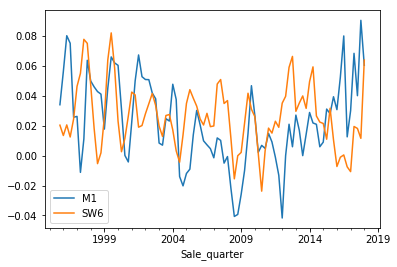

In [81]:
df_district_pc[['M1','SW6']].plot()
plt.show()